# Quadcoptor problem benchmarking

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Documents/codes/jl/SCPLib.jl`


In [322]:
using Clarabel
using ForwardDiff
using GLMakie
using JuMP
using LinearAlgebra
using OrdinaryDiffEq
using Printf

include(joinpath(@__DIR__, "../src/SCPLib.jl"))

Main.SCPLib

### Solve with SCvx* (with L1 penalty)

In [287]:
function callback(solution)
    push!(iter_xs, deepcopy(solution.x))
    push!(iter_us, deepcopy(solution.u))
end

callback (generic function with 1 method)

In [373]:
# get problem
prob, x_ref, u_ref = SCPLib.get_quadcopter_problem(Clarabel.Optimizer);

# get algorithm
algo_name = "scvxstar"   # "proxlinear" or "scvxstar" or "scvxstarl1"
@show algo_name

if algo_name == "scvxstar"
    algo = SCPLib.SCvxStar(prob.nx, prob.N; nh=prob.nh, w0 = 1e2, l1_penalty=false)
elseif algo_name == "scvxstarl1"
    algo = SCPLib.SCvxStar(prob.nx, prob.N; nh=prob.nh, w0 = 10.0, l1_penalty=true)
elseif algo_name == "proxlinear"
    w_ep = 1e1
    w_prox = 1e0
    algo = SCPLib.ProxLinear(w_ep, w_prox)
end

# solve problem
iter_xs, iter_us = [], [] 
push!(iter_xs, deepcopy(x_ref))
push!(iter_us, deepcopy(u_ref))
tol_feas = 1e-8
tol_opt = 1e-6
solution = SCPLib.solve!(algo, prob, x_ref, u_ref; tol_opt = tol_opt, tol_feas = tol_feas, callback=callback);

algo_name = "scvxstar"

 Solving OCP with SCvx* Algorithm (`・ω・´)

   Feasibility tolerance tol_feas :  1.00e-08
   Optimality tolerance tol_opt   :  1.00e-06
   Objective tolerance tol_J0     : -1.00e+16

Iter |     J0     |    ΔJ_i   |    ΔL_i    |     χ_i    |   ρ_i    |   r_i    |    w     |  acpt. |
   1 |  1.398e+02 | 4.086e+01 |  3.963e+01 |  4.934e-01 | 1.03e+00 | 5.00e-02 | 1.00e+02 |  yes   |
   2 |  1.444e+02 | 2.275e+02 |  2.211e+02 |  3.452e-01 | 1.03e+00 | 1.50e-01 | 2.00e+02 |  yes   |
   3 |  1.461e+02 | 2.435e+02 |  2.447e+02 |  1.173e-01 | 9.95e-01 | 4.50e-01 | 2.00e+02 |  yes   |
   4 |  1.516e+02 | 9.032e+01 |  1.217e+02 |  8.911e-02 | 7.42e-01 | 1.35e+00 | 2.00e+02 |  yes   |
   5 |  1.558e+02 | 3.247e+01 |  3.354e+01 |  9.147e-02 | 9.68e-01 | 4.05e+00 | 2.00e+02 |  yes   |
   6 |  1.516e+02 | 3.666e+01 |  3.870e+01 |  4.640e-02 | 9.47e-01 | 1.22e+01 | 4.00e+02 |  yes   |
   7 |  1.522e+02 | 6.785e+00 |  6.330e+00 |  3.409e-02 | 1.07e+00 | 3.65e+01 | 8.00e+02 |  ye

In [374]:
@printf("Objective = %1.4f\n", solution.info[:J0][end])

Objective = 153.8876


In [375]:
# obstacle avoidance parameters
R_obstacle_1 = 1.0              # m, radius of obstacle 1
p_obstacle_1 = [0, 3, 0.45]     # m, position of obstacle 1
R_obstacle_2 = 1.0              # m, radius of obstacle 2
p_obstacle_2 = [0, 7, -0.45]    # m, position of obstacle 2

3-element Vector{Float64}:
  0.0
  7.0
 -0.45

In [376]:
function band_circle!(ax, R, center; color=:red, alpha=0.1)
    coord_upper = R * [cos.(LinRange(0, pi, 100)) sin.(LinRange(0, pi, 100))]'
    coord_lower = R * [cos.(LinRange(0, pi, 100)) -sin.(LinRange(0, pi, 100))]'
    band!(ax, coord_upper[1,:] .+ center[1],
        coord_lower[2,:] .+ center[2], coord_upper[2,:].+ center[2],
        color=color, alpha=alpha)
    lines!(ax, coord_lower[1,:] .+ center[1], coord_lower[2,:] .+ center[2], color=color)
    lines!(ax, coord_upper[1,:] .+ center[1], coord_upper[2,:] .+ center[2], color=color)
    return coord_lower, coord_upper
end

band_circle! (generic function with 1 method)

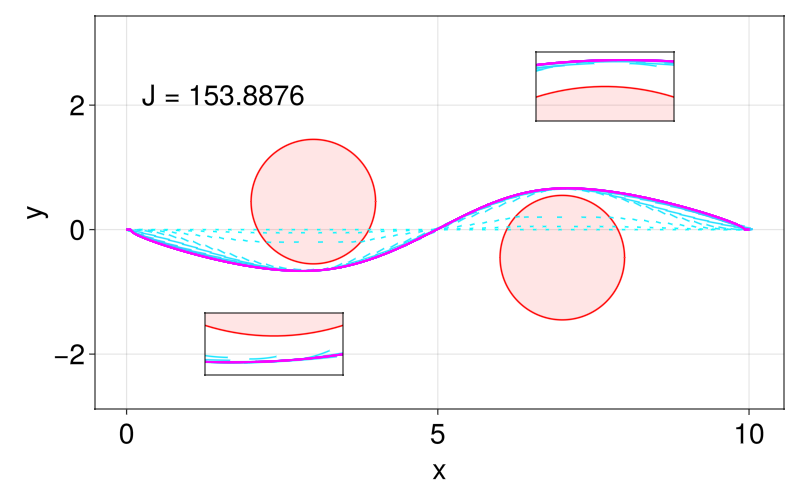

In [377]:
fontsize = 28

fig = Figure(size=(800,500))
ax = Axis(fig[1,1]; autolimitaspect=1, xlabel="x", ylabel="y",
    xlabelsize=fontsize, ylabelsize=fontsize,
    xticklabelsize=fontsize, yticklabelsize=fontsize)

J_string = string(round(solution.info[:J0][end] * 1e4)/1e4)
text!(0.25, 2.0, text = "J = $(J_string)", align = (:left, :baseline), fontsize=fontsize)

ax_zoom1 = Axis(fig[1,1]; aspect=DataAspect(), width=Relative(0.2), height=Relative(0.2), halign=0.8, valign=0.9,
    xlabelsize=fontsize-4, ylabelsize=fontsize-4, xticklabelsize=fontsize-4, yticklabelsize=fontsize-4)
xlims!(ax_zoom1, 6.7, 7.3)
ylims!(ax_zoom1, 0.4, 0.7)
hidedecorations!(ax_zoom1)

ax_zoom2 = Axis(fig[1,1]; aspect=DataAspect(), width=Relative(0.2), height=Relative(0.2), halign=0.2, valign=0.08,
    xlabelsize=fontsize-4, ylabelsize=fontsize-4, xticklabelsize=fontsize-4, yticklabelsize=fontsize-4)
xlims!(ax_zoom2, 2.7, 3.3)
ylims!(ax_zoom2, -0.72, -0.45)
hidedecorations!(ax_zoom2)

# plot obstacles
for _ax in [ax, ax_zoom1, ax_zoom2]
    band_circle!(_ax, R_obstacle_1, p_obstacle_1[2:3])
    band_circle!(_ax, R_obstacle_2, p_obstacle_2[2:3])
end

colors = cgrad(:cool, length(iter_xs), categorical = true)
for (idx, (_xs, _us)) in enumerate(zip(iter_xs, iter_us))
# for (idx, (_xs, _us)) in enumerate(zip(iter_xs[end-1:end], iter_us[end-1:end]))
    _sols, _ = SCPLib.get_trajectory(prob, _xs, _us)
    for _sol in _sols
        for _ax in [ax, ax_zoom1, ax_zoom2]
            lines!(_ax, Array(_sol)[2,:], Array(_sol)[3,:], color=colors[idx], linewidth=1.5)
        end
    end 
end

save("plots/quadcoptor_traj_$(algo_name).png", fig; px_per_unit=5)
fig

In [364]:
# check solve speed
N_redo = 10
t_cpus = []

for i in 0:N_redo
    # get problem
    prob, x_ref, u_ref = SCPLib.get_quadcopter_problem(Clarabel.Optimizer);
    
    # get algorithm
    algo_name = "proxlinear"   # "proxlinear" or "scvxstar" or "scvxstarl1"
    @show algo_name
    
    if algo_name == "scvxstar"
        algo = SCPLib.SCvxStar(prob.nx, prob.N; nh=prob.nh, w0 = 10.0, l1_penalty=false)
    elseif algo_name == "scvxstarl1"
        algo = SCPLib.SCvxStar(prob.nx, prob.N; nh=prob.nh, w0 = 10.0, l1_penalty=true)
    elseif algo_name == "proxlinear"
        w_ep = 1e1
        w_prox = 1e0
        algo = SCPLib.ProxLinear(w_ep, w_prox)
    end
    
    # solve problem
    iter_xs, iter_us = [], [] 
    push!(iter_xs, deepcopy(x_ref))
    push!(iter_us, deepcopy(u_ref))
    tol_feas = 1e-8
    tol_opt = 1e-6
    tstart = time()
    solution = SCPLib.solve!(algo, prob, x_ref, u_ref; verbosity=1, tol_opt = tol_opt, tol_feas = tol_feas, callback=callback)
    if i >= 1
        push!(t_cpus, time() - tstart)
    end
end

algo_name = "proxlinear"

 Solving OCP with prox-linear Algorithm (`・ω・´)

   Feasibility tolerance tol_feas :  1.00e-08
   Optimality tolerance tol_opt   :  1.00e-06
   Objective tolerance tol_J0     : -1.00e+16

Iter |     J0     |  nrm(G,1)  |  nrm(H,1)  |  nrm(ΔZ,2) |    χ_i    |  acpt. |
   1 |  1.463e+02 |  3.004e+00 |  9.638e-02 |  7.820e+00 | 1.537e-01 |  yes   |
   2 |  1.505e+02 |  9.084e-02 |  2.905e-09 |  4.399e+00 | 5.443e-02 |  yes   |
   3 |  1.510e+02 |  1.004e-08 |  4.150e-09 |  5.613e-01 | 8.987e-04 |  yes   |
   4 |  1.509e+02 |  3.850e-08 |  1.700e-08 |  3.287e-01 | 3.982e-04 |  yes   |
   5 |  1.509e+02 |  9.097e-08 |  4.013e-08 |  2.250e-01 | 1.670e-04 |  yes   |
   6 |  1.508e+02 |  1.070e-08 |  4.843e-09 |  1.611e-01 | 7.455e-05 |  yes   |
   7 |  1.508e+02 |  1.241e-07 |  5.520e-08 |  1.196e-01 | 3.665e-05 |  yes   |
   8 |  1.508e+02 |  8.646e-08 |  3.881e-08 |  9.063e-02 | 1.947e-05 |  yes   |
   9 |  1.508e+02 |  4.314e-08 |  1.960e-08 |  6.946e-02 | 1.056e-

In [365]:
@printf("%1.4f \\sim %1.4f\n", minimum(t_cpus), maximum(t_cpus))

3.8356 \sim 4.2605


In [366]:
t_cpus

10-element Vector{Any}:
 4.039321184158325
 4.204374074935913
 3.965845823287964
 3.972882032394409
 3.9596340656280518
 4.260474920272827
 4.01739501953125
 3.9688479900360107
 3.9867539405822754
 3.8356049060821533